In [4]:
# Import

import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article
import os
import matplotlib.pyplot as plt
from konlpy.tag import Mecab

In [ ]:
# url list 를 반환하는 함수
## 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.

def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)
    #print(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [ ]:
# 딕셔너리 생성 - key(code), value(actual catetory) 

idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [ ]:
# 카테고리별 기사들을 데이터프레임에 저장하는 함수
## url list, 카테고리를 입력값으로 받습니다.

def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [ ]:
# 크롤링할 카테고리 list 생성

code_list = [102, 103, 105]

In [ ]:
# 여러 카테고리 기사들을 데이터프레임에 저장하는 함수
## make_urllist와 make_data 함수를 호출
### 크롤링할 페이지 개수, code_list, 날짜를 입력값으로 받습니다.

def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [ ]:
df1 = make_total_data(5, code_list, 20230904)
df2 = make_total_data(5, code_list, 20231128)
df3 = make_total_data(5, code_list, 20240101)
df4 = make_total_data(5, code_list, 20240110)

In [ ]:
# 데이터프레임 파일을 csv 파일로 저장합니다.
# "/aiffel/news_crawling_project"

project_path = os.getenv("HOME") + "/aiffel/news_crawling_project"
df1.to_csv(morphs_test_csv_path + "/20230904_news.csv", index=False)
df2.to_csv(morphs_test_csv_path + "/20231128_news.csv", index=False)
df3.to_csv(morphs_test_csv_path + "/20240101_news.csv", index=False)
df4.to_csv(morphs_test_csv_path + "/20240110_news.csv", index=False)

if os.path.exists(morphs_test_csv_path):
  print('{} File Saved!'.format(morphs_test_csv_path))

In [5]:
# csv 파일을 읽어서 데이터 프레임으로

csv_path_20230904 = os.getenv("HOME") + "/aiffel/news_crawling_project/20230904_news.csv"
csv_path_20231128 = os.getenv("HOME") + "/aiffel/news_crawling_project/20231128_news.csv"
csv_path_20240101 = os.getenv("HOME") + "/aiffel/news_crawling_project/20240101_news.csv"
csv_path_20240110 = os.getenv("HOME") + "/aiffel/news_crawling_project/20240110_news.csv"
df_20230904 = pd.read_table(csv_path_20230904,sep=',')
df_20231128 = pd.read_table(csv_path_20231128,sep=',')
df_20240101 = pd.read_table(csv_path_20240101,sep=',')
df_20240110 = pd.read_table(csv_path_20240110,sep=',')

In [6]:
# 데이터 프레임 하나로 합치기

total_df = pd.concat([df_20230904,df_20231128,df_20240101,df_20240110], ignore_index = True)

In [7]:
total_df

,news,code
0,교회 신도에게 사기 친 목사 징역 8개월 선고,사회
1,"KBS춘천 ‘해무’, 춘천MBC ‘가고잡소’ 방송대상 수상",사회
2,"‘특별재난지역 선포’ 고성군, 민원 수수료 등 면제",사회
3,"강릉시, ITS국제세미나 참가…중소도시형 모델 제시",사회
4,동해안~신가평 송전선로 횡성 공청회 ‘무산’,사회
...,...,...
1195,"상장사 자회사 코인도 상폐 수순…빗썸, '갤럭시아' 거래 지원 종료",IT/과학
1196,국내 벤처기업 3만5132개···SW개발 분야 12.2%로 최다,IT/과학
1197,넥슨의 두 번째 결단은 '큐브 판매 중단'…메이플스토리 신뢰회복 가능할까,IT/과학
1198,"롯데정보통신 대표 ""오프라인서도 '칼리버스' 소비 보상 가능""[CES2024]",IT/과학


In [8]:
# 데이터 정제

In [9]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.

total_df['news'] = total_df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 중복된 샘플들 제거

total_df.drop_duplicates(subset=['news'], inplace=True)
print('뉴스 기사의 개수: ',len(total_df))

뉴스 기사의 개수:  1150


/tmp/ipykernel_49/3035217307.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  total_df['news'] = total_df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


    code  count
0  IT/과학    381
1     사회    384
2  생활/문화    385


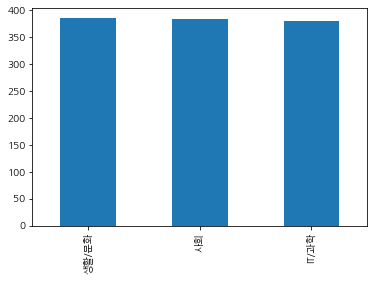

In [10]:
plt.rcParams["font.family"] = "NanumGothic"

#df['code']
total_df['code'].value_counts().plot(kind = 'bar')

print(total_df.groupby('code').size().reset_index(name = 'count'))

In [11]:
stopwords = ['은', '는', '이', '가', '을', '를', '의', '와', '과', '등', '등등', '했', '있', '에게', '께', '다', '들', '에', '대한', '었', '그리고',
 '그래서', '그런데', '하지만', '비록', '최근', '약', '대략', '할', '수', '로', '가령', '이나', '및', '한', '같은', '처럼', '하다', '에서', '인',
 '으로', '도', '한층', '더', '더욱', '몹시', '고', '요', '이번', '지난', '일', '명', '개', '월', '년']

In [12]:
print(len(stopwords))

55


In [13]:
tokenizer = Mecab()

In [14]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [15]:
text_data = preprocessing(total_df['news'])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [17]:
X_train, X_test, y_train, y_test = train_test_split(text_data, total_df['code'], random_state = 0)

In [18]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 862
테스트용 뉴스 기사의 개수 :  288
훈련용 레이블의 개수 :  862
테스트용 레이블의 개수 :  288


In [19]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [20]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [21]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [22]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [23]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [24]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.69      0.72      0.70        96
          사회       0.79      0.65      0.71        99
       생활/문화       0.63      0.72      0.67        93

    accuracy                           0.69       288
   macro avg       0.70      0.70      0.70       288
weighted avg       0.70      0.69      0.70       288



# 회고

다음에는 처음에 계획을 더 철저하게 짜야겠다는 생각이 들었다
stopwords에 너무 치중해 다른 것에 시간을 분배하지 못했다